# Training a normalizing flow with stochastic variational inference

This notebook explores how we can use Torchflows to train a normalizing flow given an unnormalized log probability density function.

We first define the log density as a torch function. In this example, we use a 11-dimensional diagonal Gaussian with mean 5 and standard deviation 2 in each dimension.

In [1]:
import torch

n_dim = 11
mean = 5
std = 2


def log_density(x):
    """
    :param x: input data with shape (*batch_shape, n_dim)
    """
    return -0.5 * torch.sum((x - mean) ** 2 / std ** 2, dim=-1)

We now create the flow object. We use a Masked Autoregressive Flow. In each training epoch, we estimate the variational loss with a single sample. We stop the training after 500 epochs of no decrease in loss value. 

In [2]:
from torchflows.flows import Flow
from torchflows.architectures import RealNVP

torch.manual_seed(0)
flow = Flow(RealNVP(event_shape=(n_dim,)))
flow.variational_fit(target_log_prob=log_density, show_progress=True, n_epochs=5000, n_samples=1, early_stopping=True, early_stopping_threshold=500)

Fitting with SVI:  28%|██▊       | 1383/5000 [00:06<00:17, 202.55it/s, Loss: 7.9173 [best: 4.6283 @ 882]] 


## Visualize the results
We create a scatterplot to see if the train flow matches the true distribution. This is possible because we used a synthetic target log density. We draw 10000 samples from the trained flow.

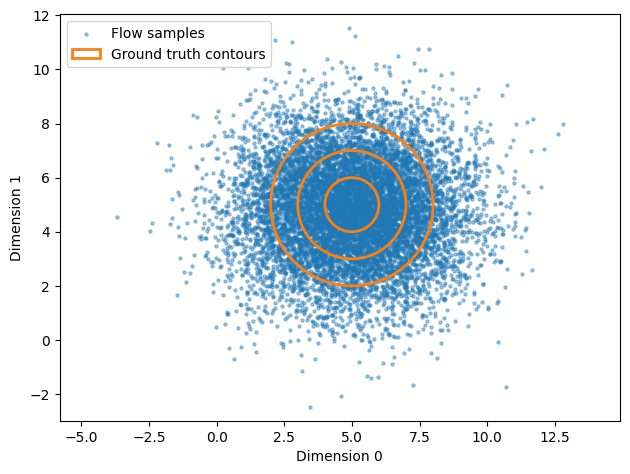

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

torch.manual_seed(0)
x_flow = flow.sample((10000,)).detach()

fig, ax = plt.subplots()
ax.scatter(x_flow[:, 0], x_flow[:, 1], label='Flow samples', s=5, alpha=0.4)
ax.add_patch(Ellipse(xy=(5, 5), height=1 * std, width=1 * std, fc='none', color='tab:orange', linewidth=2))
ax.add_patch(Ellipse(xy=(5, 5), height=2 * std, width=2 * std, fc='none', color='tab:orange', linewidth=2))
ax.add_patch(Ellipse(xy=(5, 5), height=3 * std, width=3 * std, fc='none', color='tab:orange', linewidth=2,
                     label='Ground truth contours'))
ax.legend()
ax.set_xlabel('Dimension 0')
ax.set_ylabel('Dimension 1')
ax.axis('equal')
fig.tight_layout()
plt.show()